In [307]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import json
from scipy.stats import ttest_1samp

# Processing data

In [308]:
rca = pd.read_csv('../../data/results/rca_ensemb.csv')
rca['test_n'] = (rca['train_n'] / 4).astype(int)
rca = rca.query('check =="pass" & test_n > 20')
rca

,embed,norm,train_n,fold,r2,mse,check,test_n
0,CBOW_GoogleNews,Freq_HAL,8668,1,0.660651,1.065544,pass,2167
1,CBOW_GoogleNews,Freq_HAL,8668,2,0.659874,1.047850,pass,2167
2,CBOW_GoogleNews,Freq_HAL,8668,3,0.678498,1.135581,pass,2167
3,CBOW_GoogleNews,Freq_HAL,8668,4,0.657754,1.111463,pass,2167
4,CBOW_GoogleNews,Freq_HAL,8668,5,0.687100,1.171432,pass,2167
...,...,...,...,...,...,...,...,...
7295,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,1,0.512233,0.710529,pass,125
7296,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,2,0.586266,0.844248,pass,125
7297,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,3,0.555577,0.862000,pass,125
7298,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,4,0.437230,0.919240,pass,125


In [309]:
# Changing category names to custom cat names
meta = pd.read_csv('../../data/psychNorms/psychNorms_metadata.csv', index_col=0)
meta

,description,citation,category,associated_embed,type,n_ratings
norm,,,,,,
Freq_HAL,Log10 version of frequency norms based on the ...,"Lund, K. and C. Burgess (1996). ""Producing hig...",frequency,NaN,numeric,79671
Freq_KF,Log10 version of frequency norms based on the ...,"Kučera, H. and W. N. Francis (1967). Computati...",frequency,NaN,numeric,35230
Freq_SUBTLEXUS,Log10 version of frequency norms based on the ...,"Brysbaert, M. and B. New (2009). ""Moving beyon...",frequency,NaN,numeric,57214
Freq_SUBTLEXUK,Log10 version of the frequency norms based on ...,"Van Heuven, W. J., et al. (2014). ""SUBTLEX-UK:...",frequency,NaN,numeric,61843
Freq_Blog,Log10 version of the frequency norms based on ...,"Gimenes, M. and B. New (2016). ""Worldlex: Twit...",frequency,NaN,numeric,70646
...,...,...,...,...,...,...
familiarity_vanarsdall,Ratings from 1 (highly unfamiliar) to 7 (highl...,"@article{vanarsdall2022analyzing,\n title={An...",familiarity,NaN,numeric,1200
imageability_vanarsdall,Ratings from 1 (low imagery) to 7 (high imagery),"@article{vanarsdall2022analyzing,\n title={An...",imageability,NaN,numeric,1200
familiarity_fear,Ratings from 1 (extremely infrequent) to 7 (ex...,"@article{fear1997ratings,\n title={Ratings fo...",familiarity,NaN,numeric,703


In [310]:
# Adding norm_cat to rca
rca['norm_cat'] = (
    rca['norm'].apply(lambda norm: meta.loc[norm]['category'])
    .replace({'_': ' '}, regex=True)
)
rca

,embed,norm,train_n,fold,r2,mse,check,test_n,norm_cat
0,CBOW_GoogleNews,Freq_HAL,8668,1,0.660651,1.065544,pass,2167,frequency
1,CBOW_GoogleNews,Freq_HAL,8668,2,0.659874,1.047850,pass,2167,frequency
2,CBOW_GoogleNews,Freq_HAL,8668,3,0.678498,1.135581,pass,2167,frequency
3,CBOW_GoogleNews,Freq_HAL,8668,4,0.657754,1.111463,pass,2167,frequency
4,CBOW_GoogleNews,Freq_HAL,8668,5,0.687100,1.171432,pass,2167,frequency
...,...,...,...,...,...,...,...,...,...
7295,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,1,0.512233,0.710529,pass,125,imageability
7296,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,2,0.586266,0.844248,pass,125,imageability
7297,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,3,0.555577,0.862000,pass,125,imageability
7298,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,4,0.437230,0.919240,pass,125,imageability


In [311]:
rca_mean = (
    rca[['embed', 'norm', 'r2']].groupby(['embed', 'norm'], as_index=False).mean()
    .rename(columns={'r2': 'r2_mean'})
)
rca_mean

,embed,norm,r2_mean
0,CBOW_GoogleNews,Angry_Binder,0.529488
1,CBOW_GoogleNews,AoA_Glasgow,0.604935
2,CBOW_GoogleNews,AoA_Kuper,0.580193
3,CBOW_GoogleNews,AoA_LWV,0.610645
4,CBOW_GoogleNews,Arousal_Binder,0.553350
...,...,...,...
1445,morphoNLM&PPMI_SVD_SWOW,valence_janschewitz,0.700097
1446,morphoNLM&PPMI_SVD_SWOW,valence_zupan,0.790989
1447,morphoNLM&PPMI_SVD_SWOW,visual_complexity_marrow,0.524038
1448,morphoNLM&PPMI_SVD_SWOW,visual_lyn,0.489210


In [312]:
rca_mean['norm_cat'] = (
    rca_mean['norm'].apply(lambda norm: meta.loc[norm]['category'])
)
rca_mean

,embed,norm,r2_mean,norm_cat
0,CBOW_GoogleNews,Angry_Binder,0.529488,emotion
1,CBOW_GoogleNews,AoA_Glasgow,0.604935,age_of_acquisition
2,CBOW_GoogleNews,AoA_Kuper,0.580193,age_of_acquisition
3,CBOW_GoogleNews,AoA_LWV,0.610645,age_of_acquisition
4,CBOW_GoogleNews,Arousal_Binder,0.553350,arousal
...,...,...,...,...
1445,morphoNLM&PPMI_SVD_SWOW,valence_janschewitz,0.700097,valence
1446,morphoNLM&PPMI_SVD_SWOW,valence_zupan,0.790989,valence
1447,morphoNLM&PPMI_SVD_SWOW,visual_complexity_marrow,0.524038,sensory
1448,morphoNLM&PPMI_SVD_SWOW,visual_lyn,0.489210,sensory


**Grand avgs**

In [313]:
rca_grand_avg = (
    rca_mean[['embed', 'norm_cat', 'r2_mean']]
    .groupby(['embed', 'norm_cat'], as_index=False).median(numeric_only=True)
    .rename(columns={'r2_mean': 'r2_grand_avg'})
)
rca_grand_avg

,embed,norm_cat,r2_grand_avg
0,CBOW_GoogleNews,age_of_acquisition,0.471640
1,CBOW_GoogleNews,animacy,0.704477
2,CBOW_GoogleNews,arousal,0.536712
3,CBOW_GoogleNews,associatability,0.252253
4,CBOW_GoogleNews,autidtory_lexical_decision,0.054738
...,...,...,...
130,morphoNLM&PPMI_SVD_SWOW,social/moral,0.680489
131,morphoNLM&PPMI_SVD_SWOW,space/time/quantity,0.467299
132,morphoNLM&PPMI_SVD_SWOW,this/that,0.516101
133,morphoNLM&PPMI_SVD_SWOW,valence,0.731955


In [314]:
with open('../../data/embed_to_dtype.json', 'r') as f:
    embed_to_type = json.load(f)
    
def embed_to_group(embed_name):
    if '&' in embed_name:
        name_1, name_2 = embed_name.split('&')
        return embed_to_type[name_1] + '&' + embed_to_type[name_2]
    else:
        return embed_to_type[embed_name]
    
rca_grand_avg['embed'] = rca_grand_avg['embed'].apply(embed_to_group)
rca_grand_avg = rca_grand_avg.groupby(['embed', 'norm_cat'], as_index=False).mean(numeric_only=True)
rca_grand_avg

,embed,norm_cat,r2_grand_avg
0,text,age_of_acquisition,0.401468
1,text,animacy,0.601626
2,text,arousal,0.401454
3,text,associatability,0.264646
4,text,autidtory_lexical_decision,0.056970
...,...,...,...
76,text&text,social/moral,0.647087
77,text&text,space/time/quantity,0.506645
78,text&text,this/that,0.525242
79,text&text,valence,0.641902


In [315]:
# Top embed_types
sorted_embeds = (
    rca_grand_avg.groupby('embed')['r2_grand_avg']
    .mean()
    .sort_values(ascending=True)
    .reset_index()
)
sorted_embeds

,embed,r2_grand_avg
0,text,0.366392
1,text&text,0.466011
2,text&behavior,0.475302


**grand avg diffs**

In [316]:
# Pivoting to make it easier to compute pairwise differences 
rca_wide = ( 
    rca[['embed', 'norm', 'norm_cat', 'fold', 'r2']]
    .pivot(index=['norm', 'fold', 'norm_cat'], columns='embed', values='r2')
    .reset_index()
)
rca_wide

embed,norm,fold,norm_cat,CBOW_GoogleNews,CBOW_GoogleNews&PPMI_SVD_SWOW,CBOW_GoogleNews&morphoNLM,morphoNLM,morphoNLM&PPMI_SVD_SWOW
0,Angry_Binder,1,emotion,0.451075,0.617672,0.477270,0.497775,0.628661
1,Angry_Binder,2,emotion,0.665392,0.697556,0.660971,0.456568,0.697498
2,Angry_Binder,3,emotion,0.612515,0.637159,0.617868,0.423920,0.653719
3,Angry_Binder,4,emotion,0.546103,0.611599,0.545594,0.225442,0.564086
4,Angry_Binder,5,emotion,0.372354,0.598570,0.434177,0.390407,0.630914
...,...,...,...,...,...,...,...,...
1445,visual_troche,1,sensory,0.774042,0.813851,0.814768,0.692471,0.721595
1446,visual_troche,2,sensory,0.766725,0.726652,0.798349,0.645648,0.651587
1447,visual_troche,3,sensory,0.728824,0.722114,0.720193,0.628234,0.679291
1448,visual_troche,4,sensory,0.806846,0.798616,0.791059,0.645656,0.689450


In [317]:
text_1, text_2 = 'CBOW_GoogleNews', 'morphoNLM' # Text
text_text = text_1 + '&' + text_2 # Text & Text 
text_behav_1 = text_1 + '&' + 'PPMI_SVD_SWOW' # Text and Behavior 1
text_behav_2 = text_2 + '&' + 'PPMI_SVD_SWOW' # Text and Behavior 2


# Text & Behavior - Text & Text 
rca_wide[f'{text_behav_1} vs {text_text}'] = rca_wide[text_behav_1] - rca_wide[text_text]
rca_wide[f'{text_behav_2} vs {text_text}'] = rca_wide[text_behav_2] - rca_wide[text_text]
tb_vs_tt = (
    rca_wide[['norm', 'norm_cat', f'{text_behav_1} vs {text_text}', f'{text_behav_2} vs {text_text}']]
    .melt(id_vars=['norm', 'norm_cat'])
    .rename(columns={'embed': 'comparing'})
)
tb_vs_tt['comparing'] = 'text&behavior - text&text'

In [318]:
# Text & Behavior - Text
tb_vs_t_cols = []
for text_behav_i in [text_behav_1, text_behav_2]:
    for text_j in [text_1, text_2]:
        comparing = f'{text_behav_i} vs {text_j}'
        rca_wide[comparing] = rca_wide[text_behav_i] - rca_wide[text_j]
        tb_vs_t_cols.append(comparing)
        

tb_vs_t = (
    rca_wide[['norm', 'norm_cat'] + tb_vs_t_cols]
    .melt(id_vars=['norm', 'norm_cat'])
    .rename(columns={'embed': 'comparing'})
)
tb_vs_t['comparing'] = 'text&behavior - text'

diffs = pd.concat([tb_vs_tt, tb_vs_t])
diffs

,norm,norm_cat,comparing,value
0,Angry_Binder,emotion,text&behavior - text&text,0.140401
1,Angry_Binder,emotion,text&behavior - text&text,0.036586
2,Angry_Binder,emotion,text&behavior - text&text,0.019291
3,Angry_Binder,emotion,text&behavior - text&text,0.066005
4,Angry_Binder,emotion,text&behavior - text&text,0.164393
...,...,...,...,...
5795,visual_troche,sensory,text&behavior - text,0.029124
5796,visual_troche,sensory,text&behavior - text,0.005940
5797,visual_troche,sensory,text&behavior - text,0.051057
5798,visual_troche,sensory,text&behavior - text,0.043794


In [319]:
diffs_mean = (
    diffs.groupby(['comparing', 'norm'], as_index=False)
    .mean(numeric_only=True)
    .rename(columns={'value': 'r2_diff'})
)
diffs_mean['norm_cat'] = diffs_mean['norm'].apply(lambda norm: meta.loc[norm]['category'])
diffs_mean

,comparing,norm,r2_diff,norm_cat
0,text&behavior - text,Angry_Binder,0.169588,emotion
1,text&behavior - text,AoA_Glasgow,0.127139,age_of_acquisition
2,text&behavior - text,AoA_Kuper,0.146974,age_of_acquisition
3,text&behavior - text,AoA_LWV,0.140861,age_of_acquisition
4,text&behavior - text,Arousal_Binder,0.189201,arousal
...,...,...,...,...
575,text&behavior - text&text,valence_janschewitz,0.084092,valence
576,text&behavior - text&text,valence_zupan,0.056770,valence
577,text&behavior - text&text,visual_complexity_marrow,0.040339,sensory
578,text&behavior - text&text,visual_lyn,0.072698,sensory


In [320]:
diffs_grand_avg = (
    diffs_mean.groupby(['comparing', 'norm_cat'], as_index=False)
    .median(numeric_only=True)
    .rename(columns={'r2_diff': 'r2_diff_grand_avg'})
)
diffs_grand_avg

,comparing,norm_cat,r2_diff_grand_avg
0,text&behavior - text,age_of_acquisition,0.047109
1,text&behavior - text,animacy,0.084972
2,text&behavior - text,arousal,0.193990
3,text&behavior - text,associatability,0.046096
4,text&behavior - text,autidtory_lexical_decision,0.000787
5,text&behavior - text,concreteness,0.077241
6,text&behavior - text,dominance,0.256210
7,text&behavior - text,emotion,0.176288
8,text&behavior - text,familiarity,0.007194
9,text&behavior - text,frequency,0.122764


## Plotting 

In [321]:
# Pivot rca_grand_avg for plotting
heat_df_1 = (
    rca_grand_avg
    .pivot(index='embed', columns='norm_cat', values='r2_grand_avg')
    .loc[['text', 'text&text', 'text&behavior']]
)

# Ordering norm_cats by text&behavior performance
norm_cat_order = heat_df_1.loc['text&behavior'].sort_values(ascending=True).index
heat_df_1 = heat_df_1[norm_cat_order]
heat_df_1.index = heat_df_1.index.str.replace('&', ' & ').str.title()
heat_df_1.columns = heat_df_1.columns.str.replace('_', ' ')
heat_df_1

norm_cat,autidtory lexical decision,semantic decision,naming,number of features,semantic neighborhood,familiarity,visual lexical decision,associatability,iconicity/transparency,recognition memory,...,goals/needs,semantic diversity,arousal,part of speech,dominance,animacy,frequency,social/moral,concreteness,valence
embed,,,,,,,,,,,,,,,,,,,,,
Text,0.056970,0.135697,0.132469,0.131372,0.175448,0.232669,0.217857,0.264646,0.215315,0.348204,...,0.452069,0.545436,0.401454,0.566119,0.358308,0.601626,0.554342,0.459169,0.656080,0.468458
Text & Text,0.077352,0.143636,0.175222,0.177230,0.237593,0.279185,0.294314,0.305950,0.301505,0.390813,...,0.523287,0.698977,0.550681,0.702934,0.516752,0.710189,0.734983,0.647087,0.746547,0.641902
Text & Behavior,0.055498,0.145147,0.147631,0.167659,0.229808,0.233494,0.261964,0.310741,0.311794,0.394432,...,0.614158,0.633737,0.634457,0.634670,0.650021,0.687033,0.692610,0.698461,0.712292,0.747707


In [322]:
rca_winners_bool = heat_df_1.apply(lambda col: col == col.max(), axis=0)
rca_winners_bool

norm_cat,autidtory lexical decision,semantic decision,naming,number of features,semantic neighborhood,familiarity,visual lexical decision,associatability,iconicity/transparency,recognition memory,...,goals/needs,semantic diversity,arousal,part of speech,dominance,animacy,frequency,social/moral,concreteness,valence
embed,,,,,,,,,,,,,,,,,,,,,
Text,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Text & Text,True,False,True,True,True,True,True,False,False,False,...,False,True,False,True,False,True,True,False,True,False
Text & Behavior,False,True,False,False,False,False,False,True,True,True,...,True,False,True,False,True,False,False,True,False,True


In [324]:
# Pivot diffs_grand_avg for plotting
diffs_grand_avg = (
    diffs_grand_avg
    .pivot(index='comparing', columns='norm_cat', values='r2_diff_grand_avg')
)
diffs_grand_avg = diffs_grand_avg[norm_cat_order]
diffs_grand_avg.index = diffs_grand_avg.index.str.replace('&', ' & ').str.title()
diffs_grand_avg.columns = diffs_grand_avg.columns.str.replace('_', ' ')
diffs_grand_avg

norm_cat,autidtory lexical decision,semantic decision,naming,number of features,semantic neighborhood,familiarity,visual lexical decision,associatability,iconicity/transparency,recognition memory,...,goals/needs,semantic diversity,arousal,part of speech,dominance,animacy,frequency,social/moral,concreteness,valence
comparing,,,,,,,,,,,,,,,,,,,,,
Text & Behavior - Text,0.000787,-0.001488,0.015161,0.036287,0.074871,0.007194,0.042353,0.046096,0.084653,0.046229,...,0.188577,0.081421,0.193990,0.068551,0.256210,0.084972,0.122764,0.183392,0.077241,0.285352
Text & Behavior - Text & Text,-0.017057,-0.024872,-0.027591,-0.009571,-0.042320,-0.043518,-0.047385,0.004791,-0.018969,0.003619,...,0.090871,-0.052202,0.075108,-0.068264,0.114612,-0.027651,-0.032038,0.050736,-0.016280,0.090047


In [325]:
heat_df_2 = pd.DataFrame(diffs_grand_avg.loc['Text & Behavior - Text']).T
heat_df_3 = pd.DataFrame(diffs_grand_avg.loc['Text & Behavior - Text & Text']).T
heat_df_3

norm_cat,autidtory lexical decision,semantic decision,naming,number of features,semantic neighborhood,familiarity,visual lexical decision,associatability,iconicity/transparency,recognition memory,...,goals/needs,semantic diversity,arousal,part of speech,dominance,animacy,frequency,social/moral,concreteness,valence
Text & Behavior - Text & Text,-0.017057,-0.024872,-0.027591,-0.009571,-0.04232,-0.043518,-0.047385,0.004791,-0.018969,0.003619,...,0.090871,-0.052202,0.075108,-0.068264,0.114612,-0.027651,-0.032038,0.050736,-0.01628,0.090047


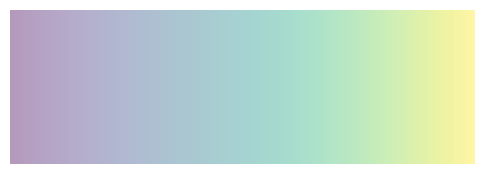

In [326]:
def lighten_cmap(cmap, factor=0.3):
    cmap = plt.cm.get_cmap(cmap, 256)  # Get the original colormap
    colors = cmap(np.linspace(0, 1, 256))

    # Blend each color with white by adjusting RGB values
    white = np.array([1, 1, 1, 1])  # RGBA for white
    new_colors = (1 - factor) * colors + factor * white

    return LinearSegmentedColormap.from_list('lighter_' + cmap.name, new_colors)


def plot_colormap(cmap):
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))

    fig, ax = plt.subplots(figsize=(6, 2))
    ax.imshow(gradient, aspect='auto', cmap=cmap)
    ax.set_axis_off()
    plt.show()


# Custom colormap: viridis with white added
viridis = plt.cm.get_cmap('viridis', 256)
new_colors = viridis(np.linspace(0, 1, 256))

# Modify the first 30% of the colormap to blend with white
new_colors[:50, :] = [1, 1, 1, 1]  # Setting white for the first 50 values
custom_cmap = LinearSegmentedColormap.from_list('viridis_white', new_colors)

# Generate a lighter version of viridis
lighter_viridis = lighten_cmap('viridis', factor=0.6)  # factor closer to 1 means lighter

# Visualize the lighter viridis colormap
plot_colormap(lighter_viridis)

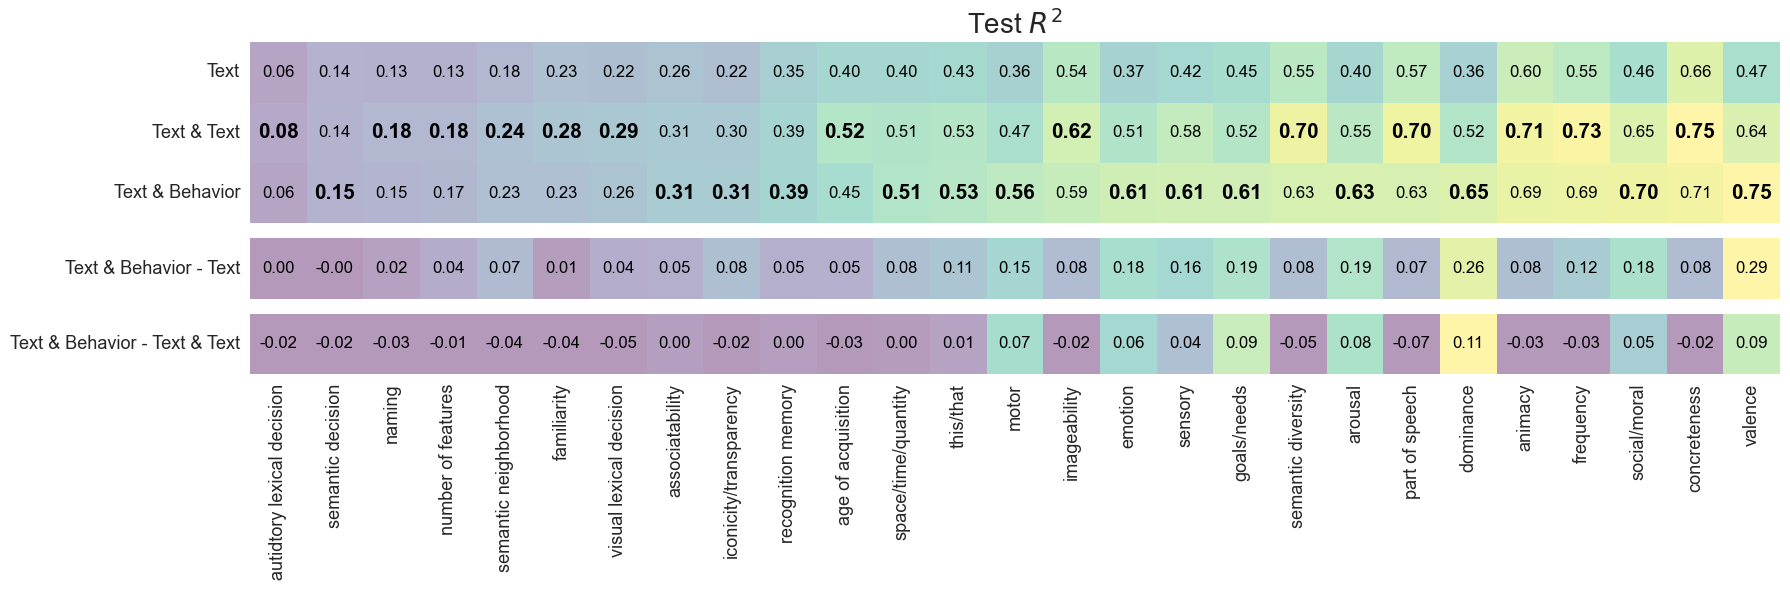

In [330]:
def annotate(heat_df, ax, winners_bool=None):
    for x, norm_cat in enumerate(heat_df.columns):
        for y, embed in enumerate(heat_df.index):
            annot = heat_df.loc[embed, norm_cat]
            
            # Scientific notation
            if abs(annot) > 1e3:
                annot = f'{annot:.1e}'
            elif np.isnan(annot):
                annot = ''
            else:
                annot = f'{annot:.2f}'
            
            # Fontsize and fontweight
            fontsize, fontweight = 12, 'normal'
            if winners_bool is not None:
                if winners_bool.loc[embed, norm_cat]:
                    fontsize, fontweight = 15, 'bold' 
            
            ax.text(
                x + .5, y + .5, annot, fontsize=fontsize, fontweight=fontweight,
                ha='center', va='center', color='black'
            )

heat_dfs = [heat_df_1, heat_df_2, heat_df_3]
fig, axs = plt.subplots(3, figsize=(18, 6), height_ratios=[len(df) for df in heat_dfs])

# Plotting grand avg
vmax = heat_df_1.max().max()
sns.heatmap(
    heat_df_1, vmin=0, cmap=lighter_viridis, 
    vmax=vmax, annot=False, fmt='', cbar=False,
    ax=axs[0]
)

# Plotting text & behavior - text
vmax = heat_df_2.max().max()
sns.heatmap(
    heat_df_2, cmap=lighter_viridis,
    vmin=0, vmax=vmax, annot=False, fmt='', cbar=False,
    ax=axs[1]
)

# Plotting text & behavior - text & text
vmax = heat_df_3.max().max()
sns.heatmap(
    heat_df_3, cmap=lighter_viridis,
    vmin=0, vmax=vmax, annot=False, fmt='', cbar=False,
    ax=axs[2]
)

for ax in axs:
    ax.set(xlabel='', ylabel='')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=13)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
    
    # rotates y-tick labels to horizontal
    plt.setp(ax.get_yticklabels(), rotation=0)

# Remove x-tick labels for all but last plot
for ax in axs[:-1]:
    ax.set_xticklabels([])

# Annotates cells
annotate(heat_df_1, axs[0], rca_winners_bool)
annotate(heat_df_2, axs[1])
annotate(heat_df_3, axs[2])

# Sets axis titles
axs[0].set_title('Test $R^2$', fontsize=20)
  
fig.tight_layout()
plt.savefig('../../figures/rca_ensemb.png', dpi=300, bbox_inches='tight')

## Paper Stats
To do: 
1. wilcoxin instead of t? 

valence diffs: 


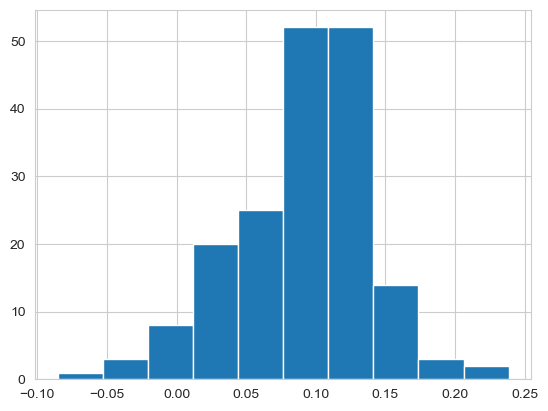

{'cat': 'valence', 'mean': 0.09, 'n': 180, 't': 25.27, 'p': 6.139943003330122e-61}
dominance diffs: 


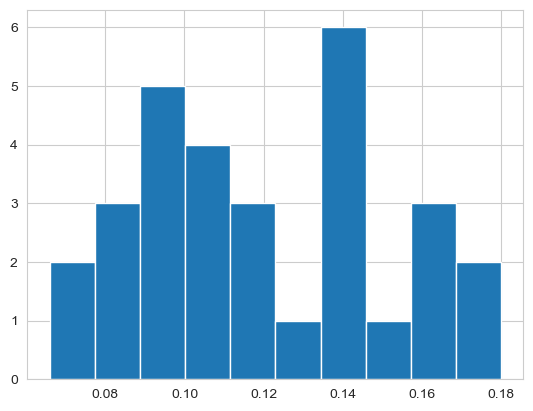

{'cat': 'dominance', 'mean': 0.12, 'n': 30, 't': 20.88, 'p': 5.079343793695236e-19}
arousal diffs: 


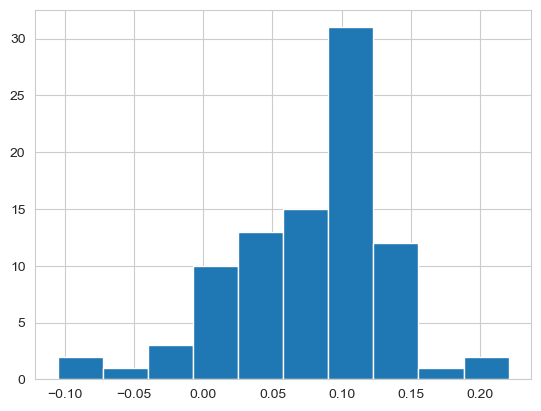

{'cat': 'arousal', 'mean': 0.08, 'n': 90, 't': 13.05, 'p': 2.2502625980251323e-22}
emotion diffs: 


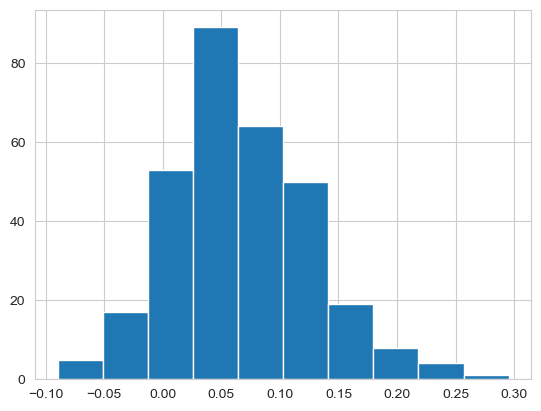

{'cat': 'emotion', 'mean': 0.07, 'n': 310, 't': 19.89, 'p': 2.8534729622503317e-57}
------------------------
goals/needs diffs: 


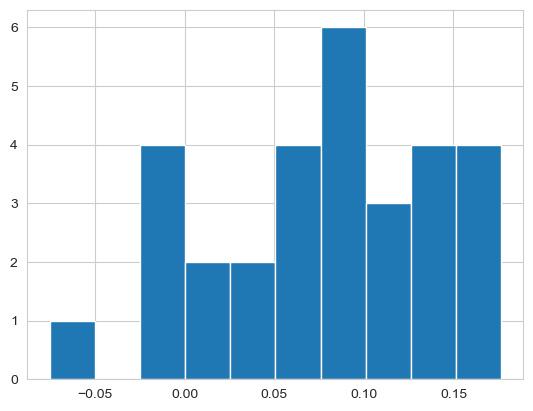

{'cat': 'goals/needs', 'mean': 0.08, 'n': 30, 't': 6.65, 'p': 2.7378322855386877e-07}
motor diffs: 


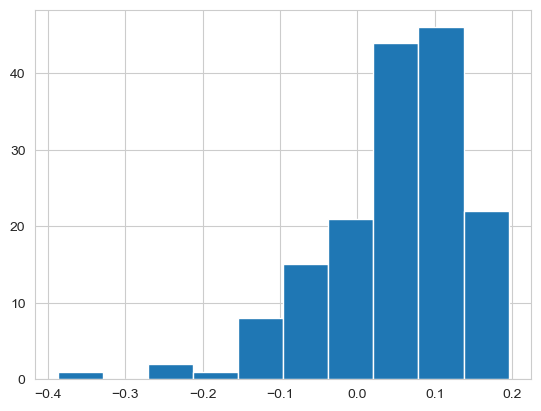

{'cat': 'motor', 'mean': 0.05, 'n': 160, 't': 6.27, 'p': 3.200774268248082e-09}
------------------------
social/moral diffs: 


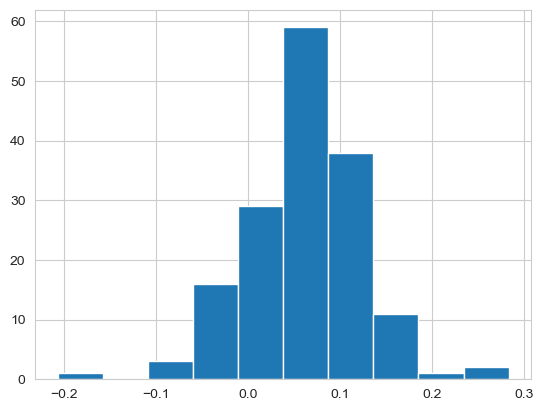

{'cat': 'social/moral', 'mean': 0.06, 'n': 160, 't': 12.13, 'p': 2.1635908003177562e-24}
------------------------
part of speech diffs: 


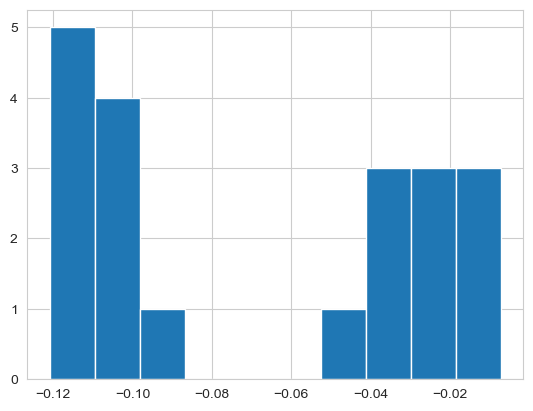

{'cat': 'part of speech', 'mean': -0.07, 'n': 20, 't': -6.91, 'p': 1.3670094933253733e-06}
semantic diversity diffs: 


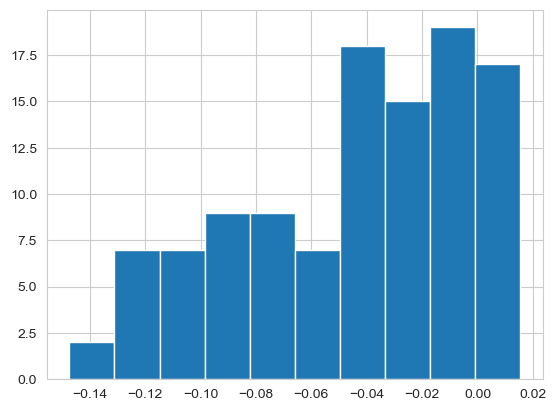

{'cat': 'semantic diversity', 'mean': -0.04, 'n': 110, 't': -11.11, 'p': 1.2702000681113762e-19}
familiarity diffs: 


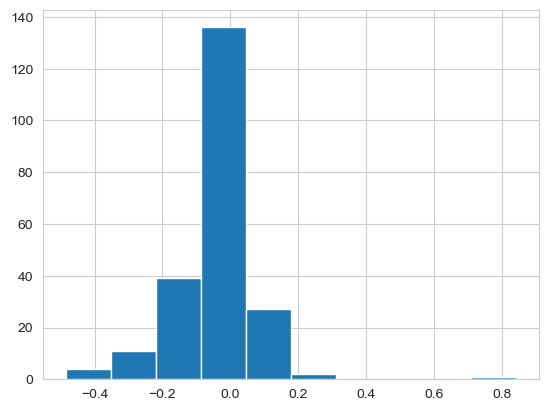

{'cat': 'familiarity', 'mean': -0.05, 'n': 220, 't': -5.79, 'p': 2.413028449008883e-08}


In [17]:
# def diff_stats(norm_cat):
#     norm_dat = rca_wide.query(f'norm_cat == "{norm_cat}"')
#     diffs = pd.concat([
#         norm_dat['morphoNLM&PPMI_SVD_SWOW'] - norm_dat['CBOW_GoogleNews&morphoNLM'],
#         norm_dat['CBOW_GoogleNews&PPMI_SVD_SWOW'] - norm_dat['CBOW_GoogleNews&morphoNLM'],
#     ])
#     
#     # Printing histogram of diffs
#     print(f'{norm_cat} diffs: ')
#     diffs.hist()
#     plt.show()
#     
#     
#     t, p = ttest_1samp(diffs, 0)
#     return {
#         'cat': norm_cat, 'mean': diffs.mean().round(2), 
#         'n': len(diffs),'t': round(t, 2), 'p': p}
# 
# # Text & Behavior > Text & Text
# print(diff_stats('valence'))
# print(diff_stats('dominance'))
# print(diff_stats('arousal'))
# print(diff_stats('emotion'))
# print('------------------------')
# print(diff_stats('goals/needs'))
# print(diff_stats('motor'))
# print('------------------------')
# print(diff_stats('social/moral'))
# 
# # Text & Behavior < Text & Text
# print('------------------------')
# print(diff_stats('part of speech'))
# print(diff_stats('semantic diversity'))
# print(diff_stats('familiarity'))

In [18]:
valence = rca_wide.query('norm_cat == "valence"')
valence_diffs = pd.concat([
    valence['morphoNLM&PPMI_SVD_SWOW'] - valence['CBOW_GoogleNews&morphoNLM'],
    valence['CBOW_GoogleNews&PPMI_SVD_SWOW'] - valence['CBOW_GoogleNews&morphoNLM'],
])

# scipy t-test for valence
ttest_1samp(valence_diffs, 0)

TtestResult(statistic=25.269566284921364, pvalue=6.139943003330122e-61, df=179)